# Self study 1

In this self study you should work on the code examples below together with the associated questions. The notebook illustrates a basic neural network implementation, where we implement most of the relevant functions from scratch, except for the calculation of the gradients, for which we rely on the functionality provided by <a urel="https://pytorch.org">PyTorch</a>. 

Since we rely on PyTorch functionality, we will also be using PyTorch's tensor data structure. This data structure operates in much the same way as numpy's ndarrays. You can find a brief introduction to PyTorch's tensors <a href="https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html">here</a>.  



The code illustrates the key concepts involved in the learning neural network. Go carefully through the code before starting to answer the questions at the end.

First we import the modules used in this selfstudy

In [2]:
import torch
from torchvision import datasets, transforms
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np

c:\Users\Stonker69\Documents\GitHub\ml_exam_notes\selfstudy\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Through torch load the MNIST data set, which we will use in this self study. The MNIST database consists of grey scale images of handwritten digits. Each image is of size $28\times 28$; see figure below for an illustration. The data set is divided into a training set consisting of $60000$ images and a test set with $10000$ images; in both
data sets the images are labeled with the correct digits. If interested, you can find more information about the MNIST data set at http://yann.lecun.com/exdb/mnist/, including accuracy results for various machine learning methods.

![MNIST DATA](MNIST-dataset.png)

Using the data loader provided by torch we have an easy way of loading in data in batches (here of size 64). We can also make various other transformation of the data, such as normalization. The details for loading the data are not really that important, but if yiu are curious, you can find a quick introduction <a href="https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html">here</a>.

In [3]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=batch_size, shuffle=True)

In the cell above, we are loading data in batches, which is subsequently used during optimization. We didn't discuss batch based learning during the last lecture, but please take a look at Slides 24 and 25 to get the gist of the approach. We will cover it in more detail during the next lecture.   

Each batch is a list of two elements. The first element encodes the digit and has dimensions [64,1,28,28] (the figures are greyscale with no rbg channel, hence the '1'), and the second element contains the class/label information. 

Batch dimension (digit): torch.Size([32, 1, 28, 28])
Batch dimension (target): torch.Size([32])
Target: 4 with shape torch.Size([])


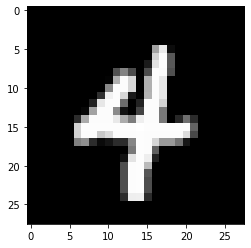

In [4]:
batch = iter(train_loader).next()
print(f"Batch dimension (digit): {batch[0].shape}")
print(f"Batch dimension (target): {batch[1].shape}")
digit_batch = batch[0]
img = digit_batch[0,:]
pyplot.imshow(img.reshape((28, 28)), cmap="gray")
print(f"Target: {batch[1][0]} with shape {batch[1][0].shape}")

With PyTorch we can specify that the tensors require gradients. This will make PyTorch record all operations performed on the tensors, so that we can afterwards calculate the gradients automatically using back propagation. See also the code example from the last lecture.

For the first part of this self study we will specify a neural network, which will encode a softmax function (see, e.g., Page 180 in <a href="https://www.deeplearningbook.org/contents/mlp.html">The Deep Learning book</a>). For this we need a (randomly initialized) weight matrix and a bias, and for both of them we need their gradients wrt. our error function (yet to be defined) in order to perform learning. Note that to facilitate matrix multiplication we will flatten our image from $28\times 28$ to $784$. 

In [5]:
def get_weights_and_bias():
    weights = torch.randn(784, 10) / np.sqrt(784)
    weights.requires_grad_()
    bias = torch.zeros(10, requires_grad=True)

    return weights, bias

Out model specification

In [6]:
def softmax(x):
    return x.exp() / x.exp().sum(-1).unsqueeze(-1)

def model(weights, bias, xb):
    return softmax(xb @ weights + bias)

Let's test our model (with our randomly initialized weights)

In [7]:
# We flatten the digit representation so that it is consistent with the weight matrix
weights, bias, = get_weights_and_bias()
xb = digit_batch.flatten(start_dim=1)
print(f"Batch shape: {xb.shape}")
preds = model(weights, bias, xb)
print(f"Prediction on first image {preds[0]}")
print(f"Corresponding classification: {preds[0].argmax()}")

Batch shape: torch.Size([32, 784])
Prediction on first image tensor([0.2181, 0.0379, 0.0407, 0.0574, 0.1039, 0.1609, 0.0649, 0.0615, 0.1094,
        0.1453], grad_fn=<SelectBackward0>)
Corresponding classification: 0


Next we define our loss function, in this case the log-loss (or negative log-likelihood):

In [8]:
def nll(input, target):
    return (-input[range(target.shape[0]), target].log()).mean() 
loss_func = nll

# L1 regularization has effect of pusing weights towards zero, this will create sparse weight
# representation
# L2 regularization has effect of pushing weights toward the origin, as it penalizes the norm of the weight

def nll_reg(input, target, l2_alpha=None, l1_alpha=None):
    l1_term = 0 
    l2_term = 0
    if l1_alpha:
        l1_term = l1_alpha * (weights.abs().sum())
    if l2_alpha:
        l2_term = (l2_alpha / 2) * (weights.pow(2)).sum()     
    return nll(input, target) + l1_term + l2_term

# Make a test calculation
yb = batch[1]
print(loss_func(preds,yb))

tensor(2.2898, grad_fn=<MeanBackward0>)


In the end, we are interested in the accuracy of our model

In [9]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [10]:
print(f"Accuracy of model on batch (with random weights): {accuracy(preds, yb)}")

Accuracy of model on batch (with random weights): 0.125


Now we are ready to combine it all and perform learning

In [15]:
epochs = 1  # how many epochs to train for
lr = 0.01  # learning rate
alpha=0.9

def train_model(lr, use_mometum=False):
    train_losses = []
    weights, bias = get_weights_and_bias()
    v = torch.zeros(weights.shape, requires_grad=False) # momentum 
    for epoch in range(epochs):

        for batch_idx, (xb, yb) in enumerate(train_loader):

            xb = xb.squeeze().flatten(start_dim=1)
            pred = model(weights, bias, xb)
            # We specify the loss
            loss = loss_func(pred, yb)
            # and perform backpropagation    
            loss.backward()
            # Lastly we update the weights and bias (torch.no_grad() ensures that no gradient 
            # calculations are taking place in this part of the code)
            with torch.no_grad():
                if use_mometum:
                    v = alpha * v - lr * weights.grad
                    weights += v
                else:
                    weights -= lr * weights.grad
                bias -= bias.grad * lr
                # weights -= weights.grad * lr
                bias -= bias.grad * lr
                
                # After updating we set the gradients to zero so that we ar eready for the next round
                weights.grad.zero_()
                bias.grad.zero_()
                        
                if batch_idx % 50 == 0:
                    with torch.no_grad():
                        train_loss = np.mean([loss_func(model(weights, bias, txb.squeeze().flatten(start_dim=1)), tyb).item() for txb, tyb in train_loader])
                        print(f"Epoch: {epoch}, B-idx: {batch_idx}, Training loss: {train_loss}")
                        train_losses.append(train_loss)
    plt.plot(range(len(train_losses)), train_losses)
    plt.savefig(f"images/default_lr_{lr}_bs_{batch_size}_momentum_{alpha}.jpg", bbox_inches='tight')
    plt.clf()
    return weights, bias

In [ ]:
for lr in [0.02]:
    train_model(lr)

Plot the evolution of the training loss

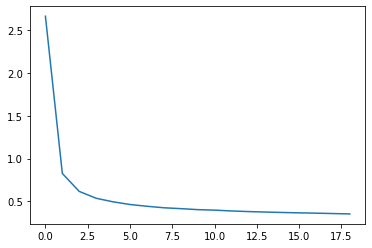

__Exercise:__ 
1. Experiment with different variations of the gradient descent implementation; try varying the learning rate and the batch size. Assuming that you have a fixed time budget (say 2 minutes for learning), what can we then say about the effect of changing the parameters?


### lr=0.01, batchsize=32 | lr=0.005, batchsize=32
![](images\default_lr_0.01_bs_32.jpg) ![](images\default_lr_0.005_bs_32.jpg)

### lr=0.02, batchsize=32 | lr=0.1, batchsize=32
![](images\default_lr_0.02_bs_32.jpg) ![](images\default_lr_0.1_bs_32.jpg)

### lr=0.01, batchsize=64 | lr=0.005, batchsize=64
![](images\default_lr_0.01_bs_64.jpg) ![](images\default_lr_0.005_bs_64.jpg)

### lr=0.02, batchsize=64 | lr=0.1, batchsize=64
![](images\default_lr_0.02_bs_64.jpg) ![](images\default_lr_0.1_bs_64.jpg)

### Observations
- Batchsizes are close to eachother, but it seems a larger is better
- Learning rate is best for 0.02, where a larger one impacts negatively, and a smaller converges slower

2. Implement momentum in the learning algorithm. How does it affect the results?
    - $\mathbf{v} = \alpha \mathbf{v} -  \eta\nabla_{\mathbf{w}} \left( \frac{1}{N}\sum_{i=1}^N \mathcal{L}(y,\hat{y})\right)$
    - $\mathbf{w} = \mathbf{w} + \mathbf{v}$ 
- so it will increase the velocity in changing the gradient if over many steps the direction is the same
- exponentially weighted average of the gradient 
- maximum speed up of $\frac{\eta||\mathbf{g}||}{1 - \alpha}$

### With momentum | without momentum
![](images\default_lr_0.02_bs_32_momentum_0.9.jpg) ![](images\default_lr_0.02_bs_32.jpg)

- it seems to start lower with momemtum, 
- but it seems not to make too big difference, lr=0.02, bs=32, momentum_alpha=0.9

3. Try with different initialization schemes for the parameters (e.g. allowing for larger values). How does it affect the behavior of the algorithm?

- the default one uses the initalization idea from book
- will try the one mentionened in the Michael Nielsen book, that setting std to (1/sqrt(n_input))
  to try to minimize the std of the output of the neurons so as not to have std = sqrt(n_input), which can if using sigmoid activation function as it could saturate the gradient, especially for mse,
  however we are not using the sigmoid, so not a problem in our case

- Aim: can se the above is already default so will try effect of removing / sqrt(784)
- Outcome: gave nan values everywhere, so likely the softmax get overflow, so we must ensure reasonable range for the output of the neurons

4. Analyze the behavior of the algorithm on the test set and implement a method for evaluating the accuracy over the entire training/test set.

In [16]:
weights, bias = train_model(lr=0.02, use_mometum=True)

Epoch: 0, B-idx: 0, Training loss: 2.2405913999557496
Epoch: 0, B-idx: 50, Training loss: 0.6401373228400946
Epoch: 0, B-idx: 100, Training loss: 0.5994128753721714
Epoch: 0, B-idx: 150, Training loss: 0.5555765027036269
Epoch: 0, B-idx: 200, Training loss: 0.5571457183003425
Epoch: 0, B-idx: 250, Training loss: 0.5683986774250865
Epoch: 0, B-idx: 300, Training loss: 0.5448741458247105
Epoch: 0, B-idx: 350, Training loss: 0.5475505034923553
Epoch: 0, B-idx: 400, Training loss: 0.6160230203936498
Epoch: 0, B-idx: 450, Training loss: 0.5199012974354128
Epoch: 0, B-idx: 500, Training loss: 0.5175050687909126
Epoch: 0, B-idx: 550, Training loss: 0.5344388088385265
Epoch: 0, B-idx: 600, Training loss: 0.4598875630661845
Epoch: 0, B-idx: 650, Training loss: 0.5022315629169345
Epoch: 0, B-idx: 700, Training loss: 0.4620437698667248
Epoch: 0, B-idx: 750, Training loss: 0.4970148522714774
Epoch: 0, B-idx: 800, Training loss: 0.4866243858878811
Epoch: 0, B-idx: 850, Training loss: 0.604079597542

<Figure size 432x288 with 0 Axes>

In [17]:
# accuracy + loss function 
def acc_loss(model, weights, bias, data_loader):
    acc = [] 
    loss = []
    with torch.no_grad():
        for xb, yb in data_loader:
            xb = xb.squeeze().flatten(start_dim=1)
            out = model(weights, bias, xb)
            acc.append(accuracy(out, yb))
            loss.append(loss_func(out, yb))
    return np.mean(acc), np.mean(loss)

tr_acc, tr_loss = acc_loss(model, weights, bias, train_loader)
te_acc, te_loss = acc_loss(model, weights, bias, test_loader)

In [18]:
print(f"Training accuracy: {tr_acc}, Training loss: {tr_loss}")
print(f"Testing accuracy: {te_acc}, Testing loss: {te_loss}")

Training accuracy: 0.8930833339691162, Training loss: 0.46255001425743103
Testing accuracy: 0.8937699794769287, Testing loss: 0.4743281900882721


5. If you feel adventorous, you are welcome to try to specify and experiment with other more advanced model architectures (cell 23). 